# A machine learning based controller to set and regulate non-visual lighting metrics of a tunable lighting system using visual light parameters

This project aims to develop a regression model to establish a relationship between selected visual metrics and the MDER and MEDI, simultaneously of a Phillips Hue Lighting system. This relationship will then be used to achieve MDER and MEDI values by altering the color temperature and brightness settings of the Philips Hue lighting system. 

Importing the required modules and libraries 

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import requests
import json

import pandas as pd
from PIL import Image

import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

import os
import random
import string
from IPython.display import clear_output
import time

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def jprint(obj):
    # create a formatted string of the Python JSON object
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)

In [3]:
device = torch.device(0 if torch.cuda.is_available() else 'cpu') # Choosing a device to run our network on
print(device)

cpu


In [4]:
train_model = True # Set to False to run inference

### Defining our data loader 

This data was collected specifically for this project with using a spectrophotometer placed in a simulated living room equipped with a Philips Hue lighting system, over a period of a week at various hours of the day.

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data_dir):
        self.all_metrics = pd.read_csv(data_dir).drop(columns = ["date", "time", "lcone_lux", "mcone_lux", "rhlux", "scone_lux"])
        medi = self.all_metrics[['mlux']].to_numpy()
        mder = medi / self.all_metrics[['plux']].to_numpy()

        self.mMet = torch.tensor(np.hstack((medi,mder)).astype(np.float32))
        self.pMet = torch.tensor(self.all_metrics[['bri','ct']].to_numpy().astype(np.float32))
        self.data_dir = data_dir

    def __len__(self):
        return len(self.mMet)

    def __getitem__(self, idx):
        return self.mMet[idx], self.pMet[idx]

In [6]:
ds = CustomDataset('/datasets/metrics.csv')

# t_sz = int(np.floor(1 * len(ds)))
# tst_sz = int(np.ceil(0.2* len(ds)))

# train_set, test_test = torch.utils.data.random_split(ds, [t_sz, tst_sz])
trn_loader = DataLoader(ds, batch_size=8, num_workers=4, shuffle=True, drop_last=False)

train_features, out_features = next(iter(trn_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Output batch shape: {out_features.size()}")

Feature batch shape: torch.Size([8, 2])
Output batch shape: torch.Size([8, 2])


<hr>

### Defining The Model

- Input: The model takes in two features: color temperature and brightness. 

- Hidden Layers: It has two layers, each with 400 neurons. These layers help the model learn complex patterns using a function called ReLU, making the model more effective. The 400 neurons in each layer allow the model to learn detailed relationships effectively without being too complex. This setup helps the model capture important patterns while keeping it manageable. This function helps the model learn faster and more efficiently by solving some common problems in training neural networks.

- Output: It outputs two values, one for MDER and one for MEDI.

In [7]:
class Regress(nn.Module):
    def __init__(self):
        super(Regress, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 400),
            nn.ReLU(),
            nn.Linear(400, 400),
            nn.ReLU(),
            nn.Linear(400, 2),
        )

    def forward(self, x):
        outMets = self.net(x)
        return outMets

### Defining the training function

In [8]:
def training(network, optimizer, dataloader, lossFunc, loss):
    network.train() 

    loop_loss = [] # list to hold the loss for each of the images in the current batch 

    for idx, (x, out) in enumerate(dataloader): 
        x = x.float().to(device)
        net_out = network(x)
        
        # calculating loss by first flattening the output of the network to correspond with the true caption
        curr_loss = lossFunc(net_out, out)  
        
        optimizer.zero_grad()
        curr_loss.backward()
        optimizer.step()
        
        loop_loss.append(int(curr_loss))
          
    loop_loss = np.array(loop_loss).mean()
    loss.append(loop_loss)
    return loss 

### Defining hyper-parameters

In [9]:
learning_rate = 0.00005
epochs = 1000

# defining model
net = Regress().to(device)
# defining loss function that will ignore the padding tag
lossFunc = nn.MSELoss()
# defining the optmizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

### The training loop

In [11]:
if train_model:
    train_loss = []
    curr_loss = 10 # only used in first loop
    tic = time.perf_counter() # starting timer
    for i in range(epochs):
        clear_output(True)
        
        #print the number of the current epoch and the average loss for the epoch
        print("TRAINING: | Epoch [%d/%d] | Loss %.2f |" %(i+1 ,epochs , curr_loss)) 

        
        train_loss = training(net, optimizer, trn_loader, lossFunc, train_loss)
        curr_loss = train_loss[-1]
        
        # saving check points
        # torch.save({
        #       'epoch':                 i,
        #       'model_state_dict':      net.state_dict(),
        #       'optimizer_state_dict':  optimizer.state_dict(), 
        #       'loss':                  train_loss[-1]
        #   }, Save_Path)
        
        # with open("/Saved Models/loss_V3.txt", "a") as output:
        #     output.write("\n"+str(train_loss[-1]))

    toc = time.perf_counter() # stopping timer

TRAINING: | Epoch [1/1000] | Loss 10.00 |


KeyboardInterrupt: 

### Exporting model weights

In [ ]:
if train_model:    
    Save_Path = 'model_new.pt'

    torch.save({
        'epoch':                 i,
        'model_state_dict':      net.state_dict(),
        'optimizer_state_dict':  optimizer.state_dict(), 
        'loss':                  train_loss[-1]
    }, Save_Path)

    with open("/datasets/djay0011-drive/ECE4809_data/loss.txt", "a") as output:
        output.write("\n"+str(train_loss[-1]))

### Defining the validation function

In [10]:
def val_test(network,dataloader):
    num_vaid = 0
    num_y = 0

    err = []
    with torch.no_grad():
        network.eval()
        for idx, (x, y) in enumerate(dataloader):  

            y_hat = np.array(network(x.to(device)))
            y_hat = np.round(y_hat)

            err.append(list(np.square(y_hat - np.array(y))))

        print(list(err))
        rmse = np.sqrt(np.mean(err, axis = 0))
        return rmse

The following function is needed to ensure that the values output by the mode are within the range of values accepted by the Phillips Hue ligiting system.

In [11]:
def clamp_vals(vals):
    vals = list(np.round(vals.detach().numpy()))
    vals = [int(i) for i in vals]
    if vals[0] > 250:
        vals[0] = 250
    elif vals[0] < 0:
        vals[0] = 0

    if vals[1] > 500:
        vals[1] = 500
    elif vals[1] < 155:
        vals[1] = 155

    return (vals)

### Loading the previously trained model

In [12]:
Save_Path = 'model.pt'
check_point = torch.load(Save_Path)
#Checkpoint is saved as a python dictionary
#https://www.w3schools.com/python/python_dictionaries.asp
#here we unpack the dictionary to get our previous training states
net.load_state_dict(check_point['model_state_dict'])

<All keys matched successfully>

In [13]:
mlux = 120
mder = 0.67
print(mder)
x = torch.tensor(np.array([mlux,mder]).astype(np.float32))

vals_out = net(x)
vals_out = np.round(vals_out.detach().numpy())



0.67


### Testing the model in the real world 

Success. <Response [200]>
medi in:  200.0 | medi out:  49.887471583929134 | medi err:  -15.011252841607087
mder in:  0.6223 | mder out:  0.5674755940837307 | mder err:  -0.008223660887440387

Success. <Response [200]>
medi in:  215.01125284160707 | medi out:  194.6049849885847 | medi err:  -0.5395015011415296
mder in:  0.6305236608874404 | mder out:  0.6193843134205675 | mder err:  -0.0004373529869148629

Success. <Response [200]>
medi in:  200.53950150114153 | medi out:  197.3275360345702 | medi err:  -0.2672463965429813
mder in:  0.6309610138743552 | mder out:  0.6487356489034607 | mder err:  0.003965347335519109

Success. <Response [200]>
medi in:  200.267246396543 | medi out:  195.24362438876435 | medi err:  -0.4756375611235655
mder in:  0.6269956665388361 | mder out:  0.6529717870444213 | mder err:  0.004600768056663196

Success. <Response [200]>
medi in:  200.47563756112356 | medi out:  194.9135708848409 | medi err:  -0.5086429115159092
mder in:  0.6223948984821729 | mder out:  0

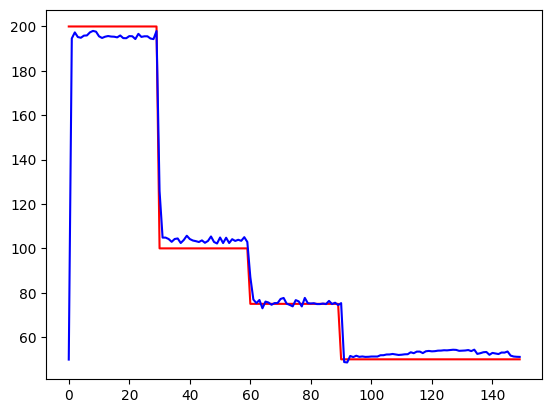

In [14]:
sleep_t = 4
spp = int(120/sleep_t)

mlux_set = np.array([200*np.ones(spp),100*np.ones(spp),75*np.ones(spp), 50*np.ones(spp), 50*np.ones(spp)]).flatten()
mder_set = np.concatenate([0.6223*np.ones(spp), 0.6026*np.ones(spp), 0.5830*np.ones(spp), np.linspace(0.6419,0.5830,num=spp*2)])

# mlux = mlux_set
# mder = mder_set

medi_arr = []
mder_arr = []

mlux_old = 0
mder_old = 0
err_medi = 0
err_mder = 0
mder_int = 0

for (mlux_cur,mder_cur) in zip(mlux_set, mder_set):

    if mlux_cur != mlux_old:
        mlux = mlux_cur
    else:
        mlux = mlux - err_medi

    if mder_cur != mder_old:
        mder = mder_cur
    else:
        mder = mder - err_mder
    
    x = torch.tensor(np.array([mlux,mder]).astype(np.float32))

    vals_out = net(x)
    vals_out = clamp_vals(vals_out)

    setParams = {"bri": vals_out[0],"ct":vals_out[1]}
    response = requests.post('<LIGHTING_CONTROL_API>', json=setParams)
    print(response.text, end = ' ')

    time.sleep(sleep_t)

    response = requests.get("<SPECTOPHOTOMETER_API>")
    print(response)
    
    # print(response.json()['mlux'])
    # print(response.json()['mlux']/response.json()['plux'])

    K1 = 0.1
    K2 = 0.15

    mdei_in = float(response.json()['mlux'])
    mder_in = float(response.json()['mlux']/response.json()['plux'])

    medi_arr.append(mdei_in)
    mder_arr.append(mder_in)

    err_medi = K1*(mdei_in - mlux_cur)
    err_mder = K2*(mder_in - mder_cur)

    print('medi in: ', (mlux), end = ' | ')
    print('medi out: ', (mdei_in), end = ' | ')
    print('medi err: ', (err_medi))
    print('mder in: ', (mder), end = ' | ')
    print('mder out: ', (mder_in), end = ' | ')
    print('mder err: ', (err_mder))
    print('')

    mlux_old = mlux_cur
    mder_old = mder_cur



fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(mlux_set, color='red')
ax.plot(medi_arr, color='blue')

plt.show()




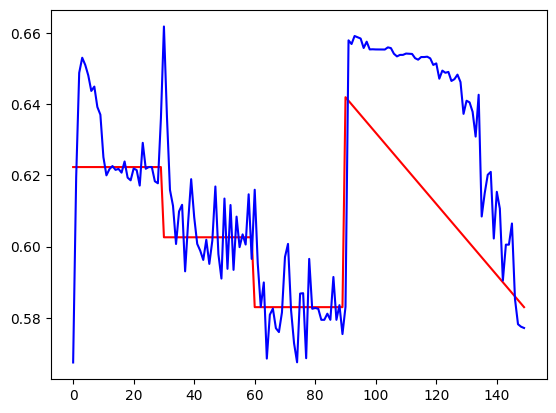

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(mder_set, color='red')
ax.plot(mder_arr, color='blue')

plt.show()

In [ ]:
mlux_set = np.array([200*np.ones(spp),100*np.ones(spp),75*np.ones(spp), 50*np.ones(spp)]).flatten()

In [25]:
x = torch.tensor(np.array([200,0.69]).astype(np.float32))

vals_out = net(x)
vals_out = clamp_vals(vals_out)

setParams = {"bri": vals_out[0],"ct":vals_out[1]}
response = requests.post('<LIGHTING_CONTROL_API>', json=setParams)
print(response.text, end = ' ')

time.sleep(sleep_t)

response = requests.get("<SPECTOPHOTOMETER_API>")
print(response)

mdei_in = float(response.json()['mlux'])
mder_in = float(response.json()['mlux']/response.json()['plux'])
print(mdei_in)
print(mder_in)


Success. <Response [200]>
188.89352938209123
0.590650112131182


In [16]:
print("MEDI RMSE: ",np.round((np.sqrt(np.mean((medi_arr-mlux_set)**2))),3))
print("MDER RMSE: ", np.round((np.sqrt(np.mean((mder_arr-mder_set)**2))),3))

MEDI RMSE:  3.298
MDER RMSE:  0.022


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1f6c4438-47a7-4cdd-a61f-335e89afc03f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>